# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups        
Sample_146  E7END6;P04070;P04070-2   16.778
Sample_072  P01023                   22.882
Sample_115  P00734                   20.551
Sample_075  P02750                   20.308
Sample_101  Q86YZ3                   12.838
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups
Sample_007  P13647           14.597
Sample_159  O43173           16.280
Sample_045  Q9BS26           14.584
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.838
            A0A075B6Q5                 13.798
            A0A075B6R2                 13.505
            A0A075B6S5                 12.355
            A0A087WSY4                 13.918
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.132
            Q9UI40;Q9UI40-2            13.254
            Q9UIW2                     12.696
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.496
            Q9UP79                     11.923
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.114,15.050,16.842,19.863,15.860,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.627,19.067,...,15.528,15.576,13.981,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.927,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.402,17.705,17.039,16.179,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.597,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.302,15.345,17.084,18.708,14.249,19.433,10.895,11.237
Sample_207,15.739,16.877,15.469,16.898,15.370,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.774,13.138,11.877,14.148,13.883,13.182,14.277,12.181,13.024,13.673
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.716,19.067,16.127,...,11.884,12.419,13.310,12.515,12.215,13.033,14.232,12.445,12.298,13.019
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.878,12.998,11.653,12.182,13.498,11.725,10.990,11.469,14.652,13.947
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.464,12.543,14.088,12.194,11.854,13.150,13.137,12.177,12.540,13.480
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.823,14.216,12.486,12.394,13.949,13.264,13.731,13.598,11.722,12.582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.092,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 315.29it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.86it/s]

100%|██████████| 2/2 [00:00<00:00,  8.77it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.84it/s]

100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

100%|██████████| 3/3 [00:00<00:00,  6.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.92it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.32it/s]

100%|██████████| 4/4 [00:00<00:00,  3.66it/s]

100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.01it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.95it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.65it/s]

100%|██████████| 5/5 [00:01<00:00,  3.49it/s]

100%|██████████| 5/5 [00:01<00:00,  3.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.44it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.52it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.63it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.51it/s]

100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.15it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.29it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.59it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.53it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.49it/s]

100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.20it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.27it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.75it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.34it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.45it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.67it/s]

100%|██████████| 8/8 [00:02<00:00,  3.78it/s]

100%|██████████| 8/8 [00:02<00:00,  3.82it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.36it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.22it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.65it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.36it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.43it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.61it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.53it/s]

100%|██████████| 9/9 [00:02<00:00,  3.55it/s]

100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.24it/s]

 30%|███       | 3/10 [00:00<00:00,  7.09it/s]

 40%|████      | 4/10 [00:00<00:01,  5.07it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.35it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.10it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.88it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.52it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.63it/s]

100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.89it/s]

 27%|██▋       | 3/11 [00:00<00:01,  7.08it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.01it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.20it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.75it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.52it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.34it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.50it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.73it/s]

100%|██████████| 11/11 [00:02<00:00,  3.95it/s]

100%|██████████| 11/11 [00:02<00:00,  4.13it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.53it/s]

 25%|██▌       | 3/12 [00:00<00:01,  7.02it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.95it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.46it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.78it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.87it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.60it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.36it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.40it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.61it/s]

100%|██████████| 12/12 [00:02<00:00,  3.72it/s]

100%|██████████| 12/12 [00:02<00:00,  4.15it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.66it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.16it/s]

 31%|███       | 4/13 [00:00<00:01,  4.92it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.36it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.43it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.10it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.10it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.09it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.15it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.20it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.31it/s]

100%|██████████| 13/13 [00:03<00:00,  3.48it/s]

100%|██████████| 13/13 [00:03<00:00,  3.61it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.73it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.08it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.96it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.23it/s]

 43%|████▎     | 6/14 [00:01<00:01,  5.13it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.05it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.73it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.01it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.53it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.22it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.14it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.24it/s]

100%|██████████| 14/14 [00:03<00:00,  3.50it/s]

100%|██████████| 14/14 [00:03<00:00,  4.08it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 13.73it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.65it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.94it/s]

 40%|████      | 6/15 [00:00<00:01,  6.51it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.04it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.74it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.53it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.43it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  4.25it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.80it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  3.67it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  3.49it/s]

100%|██████████| 15/15 [00:03<00:00,  3.53it/s]

100%|██████████| 15/15 [00:03<00:00,  4.70it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.041 0.013          0.672 0.414       0.093   
2             0.004 0.003      0.039 0.012          0.718 0.129       0.637   
3             0.002 0.000      0.022 0.009          0.708 0.121       0.616   
4             0.003 0.002      0.035 0.006          0.717 0.113       0.622   
5             0.004 0.002      0.035 0.008          0.813 0.089       0.779   
6             0.003 0.001      0.036 0.004          0.806 0.081       0.806   
7             0.003 0.001      0.038 0.011          0.801 0.086       0.811   
8             0.004 0.003      0.036 0.010          0.801 0.087       0.799   
9             0.003 0.002      0.032 0.012          0.816 0.086       0.808   
10            0.003 0.002      0.034 0.010          0.814 0.087       0.810   
11            0.003 0.002      0.028 0.009          0.819 0.081       0.821   
12            0.005 0.004      0.040 0.016          0.818 0.082       0.819   
13            0.003 0.000      0.041 0.017          0.820 0.084       0.817   
14            0.004 0.002      0.036 0.009          0.805 0.085       0.797   
15            0.003 0.001      0.032 0.013          0.802 0.087       0.798   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.156 0.128                  0.539 0.040        0.849   
2          0.123   0.664 0.087                  0.719 0.072        0.784   
3          0.135   0.647 0.093                  0.708 0.071        0.782   
4          0.112   0.658 0.085                  0.717 0.063        0.805   
5          0.112   0.789 0.071                  0.821 0.056        0.892   
6          0.109   0.800 0.068                  0.830 0.056        0.894   
7          0.102   0.800 0.065                  0.829 0.055        0.892   
8          0.101   0.795 0.066                  0.825 0.056        0.891   
9          0.103   0.807 0.071                  0.836 0.059        0.892   
10         0.115   0.807 0.078                  0.836 0.065        0.904   
11         0.098   0.815 0.063                  0.842 0.054        0.905   
12         0.104   0.814 0.069                  0.842 0.058        0.903   
13         0.105   0.814 0.071                  0.841 0.060        0.902   
14         0.102   0.796 0.068                  0.826 0.057        0.904   
15         0.090   0.796 0.064                  0.825 0.054        0.902   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.818 0.083        210.000 0.000  
2          0.072                  0.726 0.087        210.000 0.000  
3          0.075                  0.710 0.092        210.000 0.000  
4          0.068                  0.752 0.090        210.000 0.000  
5          0.055                  0.865 0.066        210.000 0.000  
6          0.052                  0.872 0.061        210.000 0.000  
7          0.053                  0.870 0.063        210.000 0.000  
8          0.053                  0.866 0.064        210.000 0.000  
9          0.054                  0.870 0.064        210.000 0.000  
10         0.054                  0.893 0.054        210.000 0.000  
11         0.054                  0.897 0.051        210.000 0.000  
12         0.054                  0.894 0.051        210.000 0.000  
13         0.054                  0.892 0.051        210.000 0.000  
14         0.054                  0.898 0.050        210.000 0.000  
15         0.054                  0.896 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 739.87it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.77it/s]

100%|██████████| 2/2 [00:00<00:00,  8.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 10.33it/s]

100%|██████████| 3/3 [00:00<00:00,  8.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.08it/s]

100%|██████████| 4/4 [00:00<00:00,  6.43it/s]

100%|██████████| 4/4 [00:00<00:00,  6.91it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 10.88it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.47it/s]

100%|██████████| 5/5 [00:00<00:00,  7.09it/s]

100%|██████████| 5/5 [00:00<00:00,  7.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 13.13it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.89it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  7.30it/s]

100%|██████████| 6/6 [00:00<00:00,  6.88it/s]

100%|██████████| 6/6 [00:00<00:00,  7.47it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 12.07it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.83it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.38it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  5.97it/s]

100%|██████████| 7/7 [00:01<00:00,  5.90it/s]

100%|██████████| 7/7 [00:01<00:00,  6.50it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.84it/s]

 50%|█████     | 4/8 [00:00<00:00,  7.61it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  7.19it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.89it/s]

 88%|████████▊ | 7/8 [00:00<00:00,  6.63it/s]

100%|██████████| 8/8 [00:01<00:00,  6.51it/s]

100%|██████████| 8/8 [00:01<00:00,  7.02it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.81it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.35it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.15it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.87it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  6.03it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  6.08it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.18it/s]

100%|██████████| 9/9 [00:01<00:00,  6.17it/s]

100%|██████████| 9/9 [00:01<00:00,  6.21it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.70it/s]

 30%|███       | 3/10 [00:00<00:00,  7.96it/s]

 40%|████      | 4/10 [00:00<00:00,  6.96it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.88it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.87it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.49it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.39it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.49it/s]

100%|██████████| 10/10 [00:01<00:00,  5.69it/s]

100%|██████████| 10/10 [00:01<00:00,  6.17it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.88it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.54it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.14it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.92it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  6.67it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.56it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.47it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.22it/s]

100%|██████████| 11/11 [00:01<00:00,  5.21it/s]

100%|██████████| 11/11 [00:01<00:00,  6.33it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 10.19it/s]

 33%|███▎      | 4/12 [00:00<00:01,  6.76it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.59it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.41it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  6.39it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  6.42it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.43it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.09it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.16it/s]

100%|██████████| 12/12 [00:01<00:00,  6.12it/s]

100%|██████████| 12/12 [00:01<00:00,  6.43it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.54it/s]

 23%|██▎       | 3/13 [00:00<00:01,  7.29it/s]

 31%|███       | 4/13 [00:00<00:01,  5.45it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.26it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.09it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.90it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.94it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.79it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  4.90it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  5.42it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.96it/s]

100%|██████████| 13/13 [00:02<00:00,  5.25it/s]

100%|██████████| 13/13 [00:02<00:00,  5.31it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.61it/s]

 21%|██▏       | 3/14 [00:00<00:01,  7.76it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.17it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.62it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.84it/s]

 50%|█████     | 7/14 [00:00<00:01,  6.66it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.31it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.32it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.45it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.30it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.47it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.44it/s]

100%|██████████| 14/14 [00:02<00:00,  6.19it/s]

100%|██████████| 14/14 [00:02<00:00,  6.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.49it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.30it/s]

 33%|███▎      | 5/15 [00:00<00:01,  8.99it/s]

 40%|████      | 6/15 [00:00<00:01,  8.57it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.39it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.43it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.29it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.39it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.42it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.43it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.44it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.24it/s]

100%|██████████| 15/15 [00:01<00:00,  8.38it/s]

100%|██████████| 15/15 [00:01<00:00,  8.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.021 0.005          0.010 0.071       0.001   
2             0.002 0.001      0.027 0.010          0.678 0.120       0.492   
3             0.002 0.000      0.021 0.005          0.720 0.119       0.549   
4             0.002 0.000      0.020 0.002          0.694 0.115       0.542   
5             0.002 0.000      0.021 0.005          0.762 0.106       0.650   
6             0.002 0.000      0.021 0.004          0.763 0.111       0.650   
7             0.002 0.000      0.019 0.001          0.769 0.111       0.679   
8             0.002 0.001      0.022 0.005          0.760 0.104       0.711   
9             0.002 0.001      0.023 0.005          0.761 0.104       0.703   
10            0.002 0.000      0.019 0.000          0.768 0.094       0.774   
11            0.002 0.000      0.021 0.004          0.770 0.089       0.769   
12            0.003 0.002      0.032 0.017          0.809 0.084       0.824   
13            0.004 0.002      0.036 0.014          0.803 0.081       0.822   
14            0.002 0.000      0.020 0.002          0.812 0.081       0.814   
15            0.002 0.000      0.019 0.000          0.810 0.080       0.815   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.856   
2          0.121   0.560 0.100                  0.657 0.063        0.704   
3          0.129   0.613 0.103                  0.693 0.068        0.763   
4          0.120   0.600 0.094                  0.681 0.063        0.758   
5          0.133   0.695 0.106                  0.750 0.081        0.862   
6          0.129   0.695 0.102                  0.749 0.078        0.859   
7          0.128   0.712 0.093                  0.760 0.074        0.868   
8          0.117   0.728 0.089                  0.771 0.073        0.872   
9          0.120   0.725 0.095                  0.769 0.076        0.873   
10         0.131   0.766 0.093                  0.801 0.078        0.893   
11         0.138   0.762 0.090                  0.799 0.073        0.895   
12         0.113   0.812 0.079                  0.840 0.068        0.912   
13         0.111   0.808 0.077                  0.837 0.066        0.910   
14         0.115   0.809 0.079                  0.838 0.067        0.916   
15         0.115   0.808 0.080                  0.837 0.068        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.825 0.087        210.000 0.000  
2          0.072                  0.684 0.085        210.000 0.000  
3          0.070                  0.707 0.096        210.000 0.000  
4          0.070                  0.698 0.094        210.000 0.000  
5          0.058                  0.823 0.076        210.000 0.000  
6          0.062                  0.817 0.080        210.000 0.000  
7          0.058                  0.833 0.076        210.000 0.000  
8          0.063                  0.839 0.080        210.000 0.000  
9          0.063                  0.837 0.080        210.000 0.000  
10         0.055                  0.863 0.068        210.000 0.000  
11         0.053                  0.862 0.065        210.000 0.000  
12         0.048                  0.889 0.057        210.000 0.000  
13         0.047                  0.886 0.057        210.000 0.000  
14         0.047                  0.898 0.055        210.000 0.000  
15         0.047                  0.898 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1113.14it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 49.33it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 52.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 46.82it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 44.09it/s]

100%|██████████| 5/5 [00:00<00:00, 43.87it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 44.17it/s]

100%|██████████| 6/6 [00:00<00:00, 42.22it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 43.89it/s]

100%|██████████| 7/7 [00:00<00:00, 41.02it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 44.16it/s]

100%|██████████| 8/8 [00:00<00:00, 40.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 44.21it/s]

100%|██████████| 9/9 [00:00<00:00, 39.96it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 44.37it/s]

100%|██████████| 10/10 [00:00<00:00, 38.57it/s]

100%|██████████| 10/10 [00:00<00:00, 39.21it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.29it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.90it/s]

100%|██████████| 11/11 [00:00<00:00, 39.14it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 44.17it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.80it/s]

100%|██████████| 12/12 [00:00<00:00, 38.82it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 44.27it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.76it/s]

100%|██████████| 13/13 [00:00<00:00, 38.61it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 44.30it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.83it/s]

100%|██████████| 14/14 [00:00<00:00, 37.53it/s]

100%|██████████| 14/14 [00:00<00:00, 38.33it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 44.46it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 39.01it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 37.68it/s]

100%|██████████| 15/15 [00:00<00:00, 38.31it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.020 0.002          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.001          0.668 0.108       0.504   
3             0.002 0.000      0.019 0.000          0.640 0.124       0.476   
4             0.002 0.000      0.019 0.000          0.631 0.118       0.471   
5             0.002 0.000      0.019 0.000          0.636 0.113       0.522   
6             0.002 0.000      0.019 0.000          0.628 0.101       0.515   
7             0.002 0.000      0.019 0.000          0.637 0.107       0.524   
8             0.002 0.000      0.019 0.000          0.666 0.101       0.618   
9             0.002 0.000      0.019 0.000          0.675 0.100       0.595   
10            0.002 0.000      0.019 0.000          0.658 0.098       0.604   
11            0.002 0.000      0.019 0.000          0.666 0.090       0.609   
12            0.002 0.000      0.019 0.000          0.671 0.091       0.610   
13            0.002 0.000      0.019 0.000          0.666 0.094       0.595   
14            0.002 0.000      0.019 0.000          0.673 0.098       0.585   
15            0.002 0.000      0.019 0.000          0.665 0.101       0.587   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.743   
2          0.091   0.568 0.079                  0.657 0.057        0.731   
3          0.099   0.538 0.088                  0.635 0.064        0.731   
4          0.105   0.532 0.090                  0.631 0.062        0.724   
5          0.108   0.567 0.091                  0.649 0.067        0.724   
6          0.112   0.559 0.092                  0.644 0.064        0.719   
7          0.098   0.568 0.079                  0.649 0.060        0.728   
8          0.124   0.635 0.095                  0.694 0.075        0.772   
9          0.115   0.625 0.089                  0.690 0.069        0.785   
10         0.115   0.623 0.088                  0.685 0.068        0.788   
11         0.098   0.630 0.074                  0.690 0.058        0.789   
12         0.097   0.633 0.072                  0.693 0.057        0.785   
13         0.100   0.621 0.074                  0.685 0.057        0.784   
14         0.103   0.619 0.077                  0.685 0.059        0.787   
15         0.113   0.616 0.087                  0.683 0.066        0.786   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.070                  0.691 0.085        210.000 0.000  
2          0.073                  0.659 0.095        210.000 0.000  
3          0.077                  0.655 0.094        210.000 0.000  
4          0.078                  0.651 0.093        210.000 0.000  
5          0.077                  0.658 0.093        210.000 0.000  
6          0.076                  0.648 0.096        210.000 0.000  
7          0.077                  0.677 0.096        210.000 0.000  
8          0.069                  0.714 0.082        210.000 0.000  
9          0.062                  0.730 0.073        210.000 0.000  
10         0.061                  0.733 0.072        210.000 0.000  
11         0.063                  0.744 0.074        210.000 0.000  
12         0.063                  0.741 0.072        210.000 0.000  
13         0.062                  0.739 0.074        210.000 0.000  
14         0.063                  0.740 0.074        210.000 0.000  
15         0.062                  0.740 0.076 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,13,15
score_time,1,13,1
test_precision,13,14,9
test_recall,11,12,8
test_f1,11,12,8
test_balanced_accuracy,11,12,8
test_roc_auc,11,15,11
test_average_precision,14,14,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.96it/s]

 27%|██▋       | 4/15 [00:00<00:01, 10.57it/s]

 40%|████      | 6/15 [00:00<00:00,  9.33it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.92it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.78it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.78it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.57it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.56it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.50it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.50it/s]

100%|██████████| 15/15 [00:01<00:00,  8.49it/s]

100%|██████████| 15/15 [00:01<00:00,  8.95it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 44.16it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.80it/s]

100%|██████████| 11/11 [00:00<00:00, 39.02it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.80it/s]

 36%|███▋      | 4/11 [00:00<00:00, 12.13it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.83it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.31it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.13it/s]

100%|██████████| 11/11 [00:01<00:00, 10.67it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


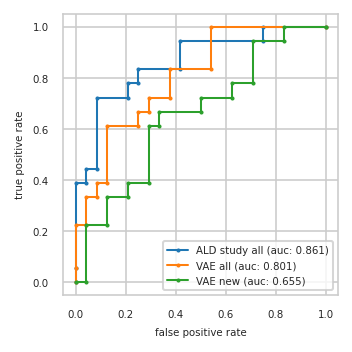

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.389   0.000 0.222   0.042 0.222
3          0.042 0.389   0.042 0.222   0.125 0.222
4          0.042 0.444   0.042 0.333   0.125 0.333
5          0.083 0.444   0.083 0.333   0.208 0.333
6          0.083 0.722   0.083 0.389   0.208 0.389
7          0.208 0.722   0.125 0.389   0.292 0.389
8          0.208 0.778   0.125 0.611   0.292 0.611
9          0.250 0.778   0.250 0.611   0.333 0.611
10         0.250 0.833   0.250 0.667   0.333 0.667
11         0.417 0.833   0.292 0.667   0.500 0.667
12         0.417 0.944   0.292 0.722   0.500 0.722
13         0.750 0.944   0.375 0.722   0.625 0.722
14         0.750 1.000   0.375 0.833   0.625 0.778
15         1.000 1.000   0.542 0.833   0.708 0.778
16           NaN   NaN   0.542 1.000   0.708 0.944
17           NaN   NaN   1.000 1.000   0.833 0.944
18           NaN   NaN     NaN   NaN   0.833 1.000
19           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,K7ER15;Q9H0R4;Q9H0R4-2,P36269;P36269-2;P36269-3
2,P09486,P02741,P30048;P30048-2
3,K7ERG9;P00746,P04075,P31321
4,P10636-2;P10636-6,P61981,E9PK25;G3V1A4;P23528
5,P14174,Q9Y2T3;Q9Y2T3-3,P51688
6,P61981,P25189;P25189-2,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,Q6EMK4,P14174,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,A0A0C4DGY8;D6RA00;Q9UHY7,Q14894,Q96GD0


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


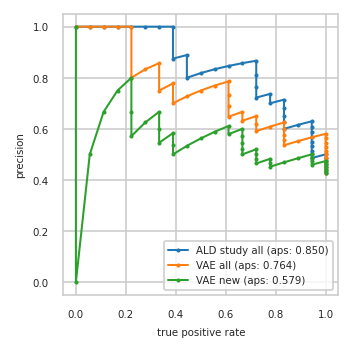

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.452 0.778
12         0.567 0.944     0.567 0.944     0.467 0.778
13         0.586 0.944     0.552 0.889     0.483 0.778
14         0.607 0.944     0.536 0.833     0.464 0.722
15         0.630 0.944     0.556 0.833     0.481 0.722
16         0.615 0.889     0.577 0.833     0.500 0.722
17         0.600 0.833     0.600 0.833     0.520 0.722
18         0.625 0.833     0.625 0.833     0.500 0.667
19         0.652 0.833     0.609 0.778     0.522 0.667
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.714 0.833     0.619 0.722     0.571 0.667
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.737 0.778     0.632 0.667     0.579 0.611
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.765 0.722     0.647 0.611     0.588 0.556
26         0.812 0.722     0.688 0.611     0.562 0.500
27         0.867 0.722     0.733 0.611     0.533 0.444
28         0.857 0.667     0.786 0.611     0.500 0.389
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.833 0.556     0.750 0.500     0.583 0.389
31         0.818 0.500     0.727 0.444     0.545 0.333
32         0.800 0.444     0.700 0.389     0.600 0.333
33         0.889 0.444     0.778 0.389     0.667 0.333
34         0.875 0.389     0.750 0.333     0.625 0.278
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


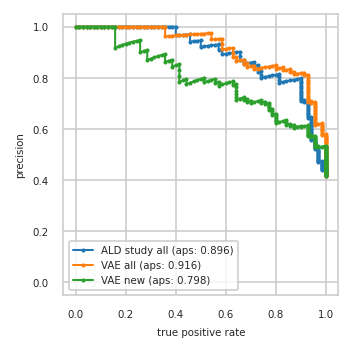

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


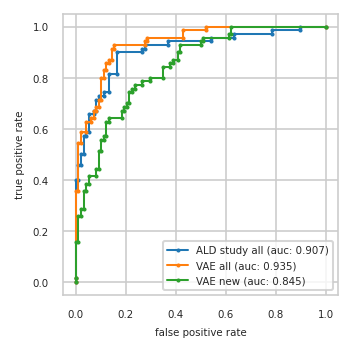

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}